In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout

# 1. Getting data

- satellite.npz

Dataset includes:

* `x` : training data (all are normal samples)
* `tx` : test data samples (some normal, some abnormal)
* `ty` : tells you which are normal and which are not.
  * our autoencoder would reconstruct every sample with
ty=0 very well, and make mistakes when ty=1

In [ ]:
# This code allows us to upload data from local drive
from google.colab import files
uploaded = files.upload()

Saving satellite.npz to satellite.npz


In [ ]:
data = np.load('satellite.npz')

In [ ]:
print(data.files)

['x', 'tx', 'ty']


In [ ]:
X_tra = data['x']
X_te = data['tx']
y_test= data['ty']

In [ ]:
X_tra

array([[ 63, 103, 110, ...,  81, 102,  83],
       [ 84,  99, 104, ..., 103, 110,  83],
       [ 56,  79, 100, ...,  92, 105,  87],
       ...,
       [ 64,  98, 111, ..., 103, 113,  96],
       [ 80,  98,  98, ...,  79,  89,  71],
       [ 87,  99, 105, ..., 115, 115,  91]], dtype=uint8)

In [ ]:
y_test

array([1, 0, 1, ..., 0, 1, 1])

In [ ]:
X_tra.shape

(3080, 36)

In [ ]:
X_te.shape

(2638, 36)

In [ ]:
X_tra.min()

31

In [ ]:
X_tra.max()

139

# 2. Feature scaling
- Using MinMaxScaler() in Scikit-learn to scale data

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_tra.copy())
X_test = scaler.transform(X_te.copy())

# 3. Create Autoencoder Model

In [ ]:
# Create a model by subclassing Model class in tensorflow
class Autoencoder(Model):
  """
  An autoencoder with Encoder and decoder blocks
  
  Arguments:
    input_dim -- number of NN units at layer 0 (input)
         
  Returns: 
    autoencoder -- autoencoder Model
  """

  def __init__(self, input_dim):
    super().__init__()
    # encoder block
    self.encoder = Sequential([
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(16, activation='relu'),
        Dropout(0.1),
        Dense(8, activation='relu'),
        Dropout(0.1),
        Dense(4, activation='relu')
    ])
    # Decoder block
    self.decoder = Sequential([
        Dense(8, activation='relu'),
        Dropout(0.1),
        Dense(16, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(input_dim, activation='sigmoid')
    ])

  def call(self, inputs):
    encode = self.encoder(inputs)
    decode = self.decoder(encode)
    return decode

## 3.a. Training model using the loss function `Mean Square Error`:

Pros of mse:
  * MSE penalises the model for having huge errors by squaring them.
  * It is particularly helpful in weeding out outliers with large errors from the model by putting more weight on them.

**source:** https://medium.com/analytics-vidhya/loss-functions-to-evaluate-regression-models-8dac47e327e2

In [ ]:
# Set random seed
tf.keras.utils.set_random_seed(42)

# Create autoencoder model
autoencoder = Autoencoder(input_dim=X_train.shape[1])

# Loss and optimizer definition
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss='mse',  #  Computes the mean of squares of errors between y_true & y_pred.
                    metrics=['mse']) 

# Training model
EPOCHS = 50
BATCH_SIZE = 128

# Fit the autoencoder
history= autoencoder.fit(x=X_train, 
                          y=X_train,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_data=(X_test, X_test),
                          shuffle=True)

Epoch 1/50
25/25 [==============================] - 6s 19ms/step - loss: 0.0408 - mse: 0.0408 - val_loss: 0.0758 - val_mse: 0.0758
Epoch 2/50
25/25 [==============================] - 0s 8ms/step - loss: 0.0374 - mse: 0.0374 - val_loss: 0.0735 - val_mse: 0.0735
Epoch 3/50
25/25 [==============================] - 0s 9ms/step - loss: 0.0322 - mse: 0.0322 - val_loss: 0.0674 - val_mse: 0.0674
Epoch 4/50
25/25 [==============================] - 0s 8ms/step - loss: 0.0272 - mse: 0.0272 - val_loss: 0.0620 - val_mse: 0.0620
Epoch 5/50
25/25 [==============================] - 0s 8ms/step - loss: 0.0223 - mse: 0.0223 - val_loss: 0.0569 - val_mse: 0.0569
Epoch 6/50
25/25 [==============================] - 0s 8ms/step - loss: 0.0182 - mse: 0.0182 - val_loss: 0.0543 - val_mse: 0.0543
Epoch 7/50
25/25 [==============================] - 0s 9ms/step - loss: 0.0164 - mse: 0.0164 - val_loss: 0.0529 - val_mse: 0.0529
Epoch 8/50
25/25 [==============================] - 0s 7ms/step - loss: 0.0156 - mse: 0.0

## 3.b. Function to measure the performance of model in detecting outlier

https://stackoverflow.com/questions/65398299/proper-inputs-for-scikit-learn-roc-auc-score-and-roc-plot

In [ ]:
def performance(model, X_test, plot = True):
  """
  Measure performance of trained model mit AUC score using built-in function in sklearn

  Arguments:
    model -- trained model
    X_test -- data which are used to test the trained model
    plot -- True: plot the ROC curve. False: does not plot the ROC curve
         
  Returns: 
    AUC -- the AUC score
    ROC curve
  """

  # getting predictions (recontructions) of the test data
  preds = model.predict(X_test)
  # calculate the difference between predictions and test data using mean square error
  pred_errors = tf.keras.losses.mse(preds, X_test)
  # Check the prediction performance
  auc_score = roc_auc_score(y_test, pred_errors)
  if not plot:
    print(f"AUC score: {auc_score}")
  else:
    preds = model.predict(X_test)
    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, threshold = roc_curve(y_test, pred_errors)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'g', label = 'AUC = %0.2f' % auc_score)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

83/83 [==============================] - 0s 2ms/step


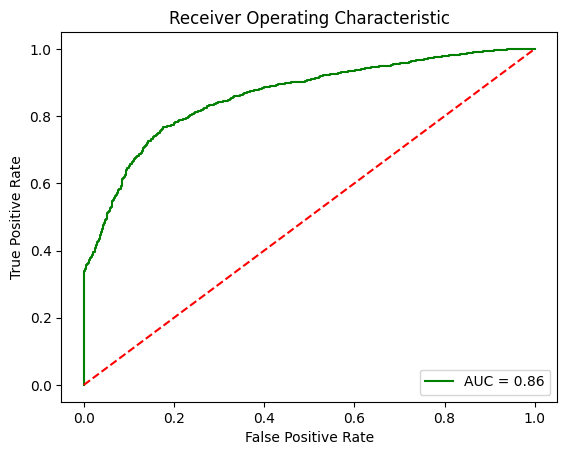

In [ ]:
performance(autoencoder, X_test)

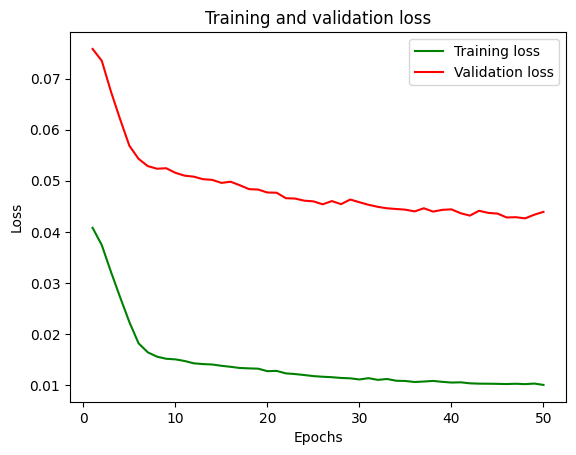

In [ ]:
# Plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 4.  Test new architecture of model

by adding or removing hidden layers

* After testing, we get the best model architecture is Autoencoder with 86% of AUC

In [ ]:
# Create a model by subclassing Model class in tensorflow
class AutoencoderV1(Model):
  """
  An autoencoder with Encoder and decoder blocks
  
  Arguments:
    input_dim -- number of NN units at layer 0 (input)
         
  Returns: 
    autoencoder -- autoencoder Model
  """

  def __init__(self, input_dim):
    super().__init__()
    # encoder block
    self.encoder = Sequential([
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(16, activation='relu'),
        Dropout(0.1),
        Dense(8, activation='relu'),
        Dropout(0.1),
        Dense(4, activation='relu')
    ])
    # Decoder block
    self.decoder = Sequential([
        Dense(8, activation='relu'),
        Dropout(0.1),
        Dense(16, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(input_dim, activation='sigmoid')
    ])

  def call(self, inputs):
    encode = self.encoder(inputs)
    decode = self.decoder(encode)
    return decode

In [ ]:
# Set random seed
tf.keras.utils.set_random_seed(42)

# Create autoencoder model
autoencoderV1 = AutoencoderV1(input_dim=X_train.shape[1])

# Loss and optimizer definition
autoencoderV1.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss='mse',  #  Computes the mean of squares of errors between y_true & y_pred.
                    metrics=['mse']) 

# Training model
EPOCHS = 40
BATCH_SIZE = 128

# Fit the autoencoder
historyV1= autoencoderV1.fit(x=X_train, 
                          y=X_train,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_data=(X_test, X_test),
                          shuffle=True)

Epoch 1/40
25/25 [==============================] - 2s 16ms/step - loss: 0.0398 - mse: 0.0398 - val_loss: 0.0751 - val_mse: 0.0751
Epoch 2/40
25/25 [==============================] - 0s 6ms/step - loss: 0.0362 - mse: 0.0362 - val_loss: 0.0728 - val_mse: 0.0728
Epoch 3/40
25/25 [==============================] - 0s 6ms/step - loss: 0.0320 - mse: 0.0320 - val_loss: 0.0682 - val_mse: 0.0682
Epoch 4/40
25/25 [==============================] - 0s 8ms/step - loss: 0.0289 - mse: 0.0289 - val_loss: 0.0645 - val_mse: 0.0645
Epoch 5/40
25/25 [==============================] - 0s 8ms/step - loss: 0.0254 - mse: 0.0254 - val_loss: 0.0592 - val_mse: 0.0592
Epoch 6/40
25/25 [==============================] - 0s 7ms/step - loss: 0.0216 - mse: 0.0216 - val_loss: 0.0533 - val_mse: 0.0533
Epoch 7/40
25/25 [==============================] - 0s 8ms/step - loss: 0.0179 - mse: 0.0179 - val_loss: 0.0489 - val_mse: 0.0489
Epoch 8/40
25/25 [==============================] - 0s 7ms/step - loss: 0.0160 - mse: 0.0

83/83 [==============================] - 0s 2ms/step


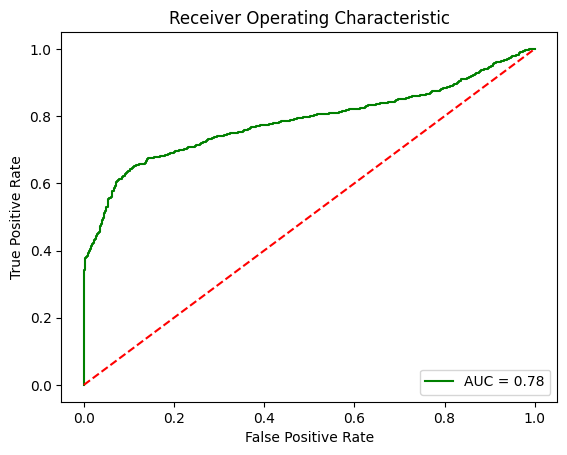

In [ ]:
performance(autoencoderV1, X_test)

In [ ]:
# Create a model by subclassing Model class in tensorflow
class AutoencoderV2(Model):
  """
  An autoencoder with Encoder and decoder blocks
  
  Arguments:
    input_dim -- number of NN units at layer 0 (input)
         
  Returns: 
    autoencoder -- autoencoder Model
  """

  def __init__(self, input_dim):
    super().__init__()
    # encoder block
    self.encoder = Sequential([
        Dense(96, activation='relu'),
        Dropout(0.1),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(16, activation='relu'),
        Dropout(0.1),
        Dense(8, activation='relu'),
        Dropout(0.1),
        Dense(4, activation='relu')
    ])
    # Decoder block
    self.decoder = Sequential([
        Dense(8, activation='relu'),
        Dropout(0.1),
        Dense(16, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(96, activation='relu'),
        Dropout(0.1),
        Dense(input_dim, activation='sigmoid')
    ])

  def call(self, inputs):
    encode = self.encoder(inputs)
    decode = self.decoder(encode)
    return decode

In [ ]:
# Set random seed
tf.keras.utils.set_random_seed(42)

# Create autoencoder model
autoencoderV2 = AutoencoderV2(input_dim=X_train.shape[1])

# Loss and optimizer definition
autoencoderV2.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss='mse',  #  Computes the mean of squares of errors between y_true & y_pred.
                    metrics=['mse']) 

# Training model
EPOCHS = 50
BATCH_SIZE = 128

# Fit the autoencoder
historyV2 = autoencoderV2.fit(x=X_train, 
                          y=X_train,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_data=(X_test, X_test),
                          shuffle=True)

Epoch 1/50
25/25 [==============================] - 3s 19ms/step - loss: 0.0397 - mse: 0.0397 - val_loss: 0.0767 - val_mse: 0.0767
Epoch 2/50
25/25 [==============================] - 0s 10ms/step - loss: 0.0348 - mse: 0.0348 - val_loss: 0.0691 - val_mse: 0.0691
Epoch 3/50
25/25 [==============================] - 0s 10ms/step - loss: 0.0267 - mse: 0.0267 - val_loss: 0.0599 - val_mse: 0.0599
Epoch 4/50
25/25 [==============================] - 0s 11ms/step - loss: 0.0191 - mse: 0.0191 - val_loss: 0.0552 - val_mse: 0.0552
Epoch 5/50
25/25 [==============================] - 0s 9ms/step - loss: 0.0169 - mse: 0.0169 - val_loss: 0.0550 - val_mse: 0.0550
Epoch 6/50
25/25 [==============================] - 0s 10ms/step - loss: 0.0155 - mse: 0.0155 - val_loss: 0.0537 - val_mse: 0.0537
Epoch 7/50
25/25 [==============================] - 0s 9ms/step - loss: 0.0155 - mse: 0.0155 - val_loss: 0.0520 - val_mse: 0.0520
Epoch 8/50
25/25 [==============================] - 0s 9ms/step - loss: 0.0150 - mse:

83/83 [==============================] - 0s 2ms/step


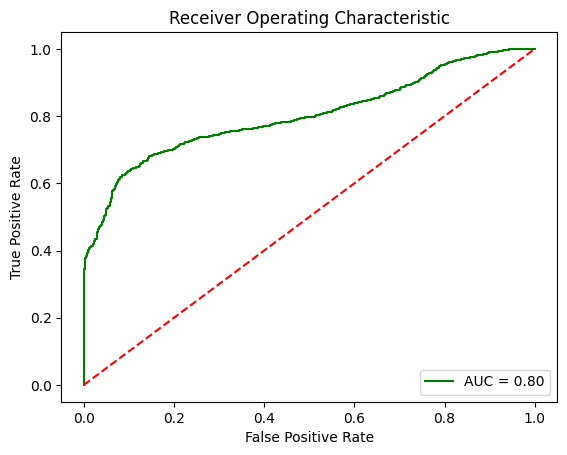

In [ ]:
performance(autoencoderV2, X_test)

In [ ]:
# Create a model by subclassing Model class in tensorflow
class AutoencoderV3(Model):
  """
  An autoencoder with Encoder and decoder blocks
  
  Arguments:
    input_dim -- number of NN units at layer 0 (input)
         
  Returns: 
    autoencoder -- autoencoder Model
  """

  def __init__(self, input_dim):
    super().__init__()
    # encoder block
    self.encoder = Sequential([
        Dense(112, activation='relu'),
        Dropout(0.1),
        Dense(96, activation='relu'),
        Dropout(0.1),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(16, activation='relu'),
        Dropout(0.1),
        Dense(8, activation='relu'),
        Dropout(0.1),
        Dense(4, activation='relu')
    ])
    # Decoder block
    self.decoder = Sequential([
        Dense(8, activation='relu'),
        Dropout(0.1),
        Dense(16, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(96, activation='relu'),
        Dropout(0.1),
        Dense(112, activation='relu'),
        Dropout(0.1),
        Dense(input_dim, activation='sigmoid')
    ])

  def call(self, inputs):
    encode = self.encoder(inputs)
    decode = self.decoder(encode)
    return decode

In [ ]:
# Set random seed
tf.keras.utils.set_random_seed(42)

# Create autoencoder model
autoencoderV3 = AutoencoderV3(input_dim=X_train.shape[1])

# Loss and optimizer definition
autoencoderV3.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss='mse',  #  Computes the mean of squares of errors between y_true & y_pred.
                    metrics=['mse']) 

# Training model
EPOCHS = 50
BATCH_SIZE = 128

# Fit the autoencoder
historyV3 = autoencoderV3.fit(x=X_train, 
                          y=X_train,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_data=(X_test, X_test),
                          shuffle=True)

Epoch 1/50
25/25 [==============================] - 4s 22ms/step - loss: 0.0397 - mse: 0.0397 - val_loss: 0.0762 - val_mse: 0.0762
Epoch 2/50
25/25 [==============================] - 0s 11ms/step - loss: 0.0331 - mse: 0.0331 - val_loss: 0.0669 - val_mse: 0.0669
Epoch 3/50
25/25 [==============================] - 0s 12ms/step - loss: 0.0240 - mse: 0.0240 - val_loss: 0.0571 - val_mse: 0.0571
Epoch 4/50
25/25 [==============================] - 0s 10ms/step - loss: 0.0163 - mse: 0.0163 - val_loss: 0.0522 - val_mse: 0.0522
Epoch 5/50
25/25 [==============================] - 0s 12ms/step - loss: 0.0149 - mse: 0.0149 - val_loss: 0.0520 - val_mse: 0.0520
Epoch 6/50
25/25 [==============================] - 0s 12ms/step - loss: 0.0146 - mse: 0.0146 - val_loss: 0.0520 - val_mse: 0.0520
Epoch 7/50
25/25 [==============================] - 0s 11ms/step - loss: 0.0141 - mse: 0.0141 - val_loss: 0.0542 - val_mse: 0.0542
Epoch 8/50
25/25 [==============================] - 0s 16ms/step - loss: 0.0137 - m

83/83 [==============================] - 0s 2ms/step


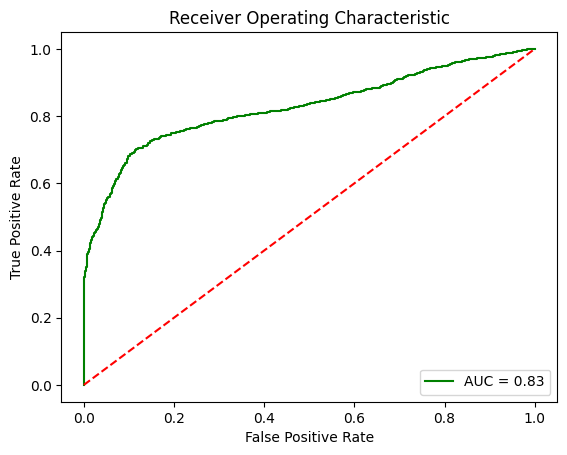

In [ ]:
performance(autoencoderV3, X_test)

# 5. Ensemble Model

Build not only a single autoencoder, but an ensemble of them: 

  * first build multiple autoencoder (in a loop)
  * then average their anomaly scores (first calculate the difference between inputs and theirs predictions, then average it)
  * Calculate the final auc score

Then create a plot, showing how this final auc score depends on the
number of models used.


*Example for using tf.math.reduce_mean()*: https://i0.wp.com/www.datasciencelearner.com/wp-content/uploads/2021/08/Mean-of-tensor-of-Multi-dimensional-row-wise.jpg?ssl=1

In [ ]:
def ensemble_model(model_architecture, seed_list, X_train, X_test, y_test, plot=True):
  """
  Create an ensemble model, which use an unique architecture, but with different numbers of random seed. 
  By setting a different random seed, we get a new model with the same architecture

  Arguments:
    model_architecture -- architecture of model, which is used to train model
    seed_list -- a list of numbers which are used to set random seed for the model
    X_train -- data which are used to train the model
    X_test -- data which are used to test the trained model
    y_test -- true labels of X_test
    plot -- True: plot the ROC curve. False: does not plot the ROC curve
         
  Returns: 
    avg_preds -- the average of predictions errors (the difference between inputs and their predictions) of all models in ensemble model
    auc_score -- the AUC score of ensemble model
    ROC curve
  """

  # list of pred_errors. Each element contains all the difference between inputs and their predictions of one model
  pred_errors_list = []

  for SEED in seed_list:
    # Set random seed
    tf.keras.utils.set_random_seed(SEED)

    # Create autoencoder model
    autoencoder = model_architecture(input_dim=X_train.shape[1])

    # Loss and optimizer definition
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(),
                        loss='mse',  #  Computes the mean of squares of errors between y_true & y_pred.
                        metrics=['mse']) 

    # Training model
    EPOCHS = 50
    BATCH_SIZE = 128

    # Fit the autoencoder
    history= autoencoder.fit(x=X_train, 
                              y=X_train,
                              epochs=EPOCHS,
                              batch_size=BATCH_SIZE,
                              validation_data=(X_test, X_test),
                              verbose=0,
                              shuffle=True)
    
    # getting predictions (recontructions) of the test data
    preds = autoencoder.predict(X_test)
    # calculate the difference between preds and test data using mean square error
    pred_errors = tf.keras.losses.mse(preds, X_test)
    # append pred_error to the pred_errors_list
    pred_errors_list.append(pred_errors)
  
  # convert pred_errors_list to a tensor
  preds_tensor = tf.convert_to_tensor(pred_errors_list)
  # calculate the average of all pred_errors in the pred_errors_list. We set axis=0, so that the average is calculated by row-weise. 
  avg_preds = tf.math.reduce_mean(preds_tensor, axis=0)
  # AUC score of the average pred_errors of all models vs. y_test
  auc_score = roc_auc_score(y_test, avg_preds)
  if not plot:
    print(f"AUC score: {auc_score}")
  else:
    preds = autoencoder.predict(X_test)
    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, threshold = roc_curve(y_test, avg_preds)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'g', label = 'AUC = %0.2f' % auc_score)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
  
  return auc_score, avg_preds

83/83 [==============================] - 0s 2ms/step


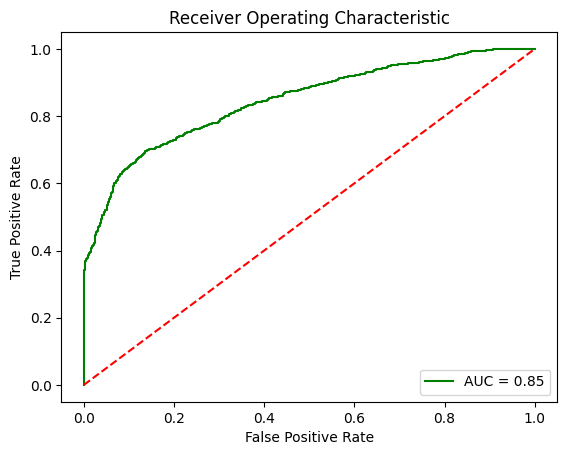

In [ ]:
# Initializing a list of SEED 
SEED_LIST = [i for i in range(6, 12)]

# Autoencoder is the best trained model. So we use this model for training ensemble
auc_score, avg_preds = ensemble_model(Autoencoder, SEED_LIST, X_train, X_test, y_test, plot=True)

In [ ]:
def plot_auc_models(model_architecture, num_models_list, X_train, X_test, y_test):
  """
  create a plot, showing how this final auc score of ensemble model depends on the number of models used.

  Arguments:
    model_architecture -- architecture of model, which is used to train model
    num_models_list -- a list contains the number of models which are integrated in one ensemble model
    X_train -- data which are used to train the model
    X_test -- data which are used to test the trained model
    y_test -- true labels of X_test
         
  Returns: 
    ROC curve
  """

  # list of auc score corresponding with the number of models integrated in an ensemble model
  AUC_LIST = []

  for i in num_models_list:
    # Create a random list of seed
    seed_list = np.random.randint(10, size=i).tolist()
    # Get the auc_score of the ensemble model which is trained by using seed_list
    auc_score, avg_preds = ensemble_model(model_architecture, seed_list, X_train, X_test, y_test, plot=False)
    AUC_LIST.append(np.round(auc_score, 3))

  # the plot display the correlation between auc score and the number of models integrated in an ensemble model
  plt.plot(num_models_list, AUC_LIST, 'g')
  plt.title('Correlation between AUC score and the number of autoencoders in an ensemble model')
  plt.xlabel('the number of autoencoders in an ensemble model')
  plt.ylabel('AUC score of ensembel models')
  plt.show()


83/83 [==============================] - 0s 2ms/step
AUC score: 0.8284143626624576
83/83 [==============================] - 0s 2ms/step
AUC score: 0.8220456717905505
83/83 [==============================] - 0s 2ms/step
AUC score: 0.8484912582820285
83/83 [==============================] - 0s 2ms/step
AUC score: 0.836011383172746


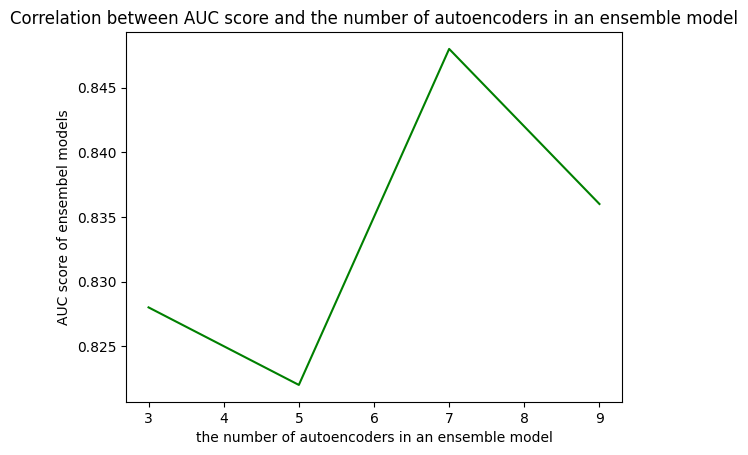

In [ ]:
np.random.seed(0)
plot_auc_models(Autoencoder, [3, 5, 7, 9], X_train, X_test, y_test)

83/83 [==============================] - 0s 2ms/step
AUC score: 0.8348945631037826
83/83 [==============================] - 0s 2ms/step
AUC score: 0.8422323526047544


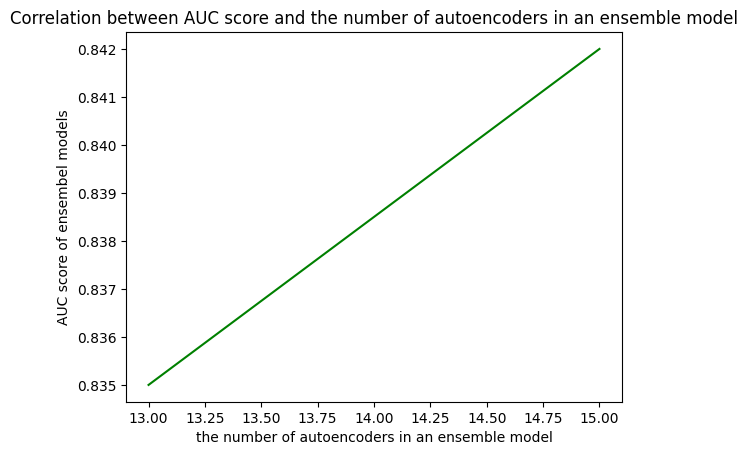

In [ ]:
np.random.seed(0)
plot_auc_models(Autoencoder, [13, 15], X_train, X_test, y_test)

* After testing with different number of models in one ensemble, we see that the result of AUC score of ensembles are not better than the autoencoderV2. They are even worse. One reason is that all models in one ensemble are quite similar or can be even identical. Because we changed only the seed number of each model in ensemble. So all models in one ensemble are high correlated with each other.

# 6. Synchronizing ensembles

Example of tf.reduce_mean for columns: https://i0.wp.com/www.datasciencelearner.com/wp-content/uploads/2021/08/Mean-of-tensor-of-Multi-dimensional-column-wise.jpg?ssl=1

In [ ]:
def sequential_synchronizing(model_architecture, num_models, X_train, X_test, y_test, plot=True):
  """Create a sequential syschronizing ensemble, in which the error of the all previous models will be used as features in the data used to train the next model.
  AUC score is calculated by using the error predictions of the last sychronized model

  Arguments:
    model_architecture -- architecture of model, which is used to train model
    num_models -- the number of models which are integrated in one sychronizing ensemble model
    X_train -- data which are used to train the model
    X_test -- data which are used to validate the model
    plot -- draw ROC curve of all trained models in ensemble
         
  Returns: 
    auc_score_list -- AUC score lists of all models during sychronizing
    avg_pred_errors_list -- list of average pred_errors. Each element contains the average of all the difference between inputs and their predictions of one model
                            each element has shape (X_train.shape[1], 1)
  """
  # Set random seed
  tf.keras.utils.set_random_seed(42)
  # list of pred_errors. Each element contains all the difference between inputs and their predictions of one model
  avg_pred_errors_list = []
  auc_score_list = []
  X = X_train.copy()

  for i in range(num_models):
    # 1. Create model
    # if pred_errors_list is not empty, then we have to concatenate the element at position i to the current training input
    if avg_pred_errors_list:
      # convert the element at position i-1 in pred_errors_list to a 2D-tensor and then convert it to a numpy array. 
      pred_current = tf.reshape(avg_pred_errors_list[i-1], [-1, 1]).numpy()
      # concatenate the pred_current to X
      X = np.concatenate((X, pred_current), axis=1)
      # concatenate the pred_current to X_test also. This new X_test will be used for later predict method   -> NEED TO CHECK THIS POINT???
      X_test = np.concatenate((X_test, pred_current[:len(X_test)]), axis=1)

    # Create autoencoder model
    autoencoder = model_architecture(input_dim=X.shape[1])


    # 2. loss and optimizer definition
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(),
                        loss='mse',  #  Computes the mean of squares of errors between y_true & y_pred.
                        metrics=['mse']) 
    # 3. Training model
    EPOCHS = 50
    BATCH_SIZE = 128
    # Fit the autoencoder
    history = autoencoder.fit(x=X, 
                              y=X,
                              epochs=EPOCHS,
                              batch_size=BATCH_SIZE,
                              validation_data=(X_test, X_test),
                              verbose=0,
                              shuffle=True)
    
    # getting predictions (recontructions) of the training data
    preds = autoencoder.predict(X)
    # calculate the difference between preds and the training data using (input - preds)**2
    pred_errors = tf.math.square(tf.math.subtract(preds, X))
    # calculate the average of pred_errors. We set axis = 1, so that the average is calculated by column-weise
    avg_preds = tf.math.reduce_mean(pred_errors, axis=1)   # shape = (X_train.shape[1], 1)
    # append avg_preds to the avg_pred_errors_list
    avg_pred_errors_list.append(avg_preds)

    # 4. Calculating AUC score of each training model
    # getting predictions of test data
    pred_test = autoencoder.predict(X_test)
    # calculate the difference between pred_test and test data 
    pred_errors_test = tf.keras.losses.mse(pred_test, X_test)
    # AUC socre 
    auc_score = round(roc_auc_score(y_test, pred_errors_test), 3)
    auc_score_list.append(auc_score)
    # 5. Plot ROC Curve
    if plot:
      fpr, tpr, threshold = roc_curve(y_test, pred_errors_test)
      plt.plot(fpr, tpr, label = f'model {i+1}: {auc_score}')
      
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  return auc_score_list, avg_pred_errors_list

83/83 [==============================] - 0s 2ms/step


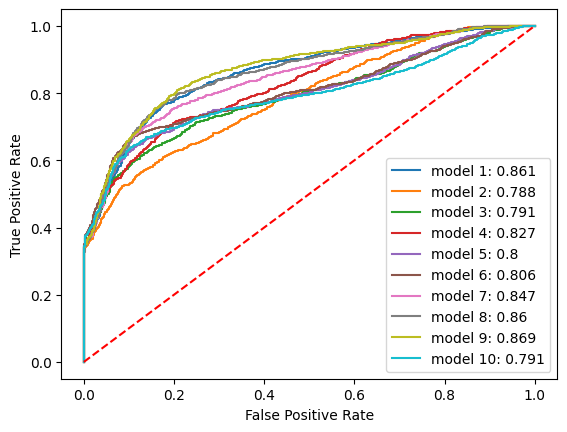

In [ ]:
auc_score_list, avg_pred_errors_list = sequential_synchronizing(Autoencoder, 10, X_train, X_test, y_test)

In [ ]:
def drop_syschronizing_ensemble(model_architecture, num_models, X_train, X_test, y_test, plot=True):
  """Create a syschronizing ensemble, in which the prediction errors of the last 
  trained model will be added as an feature to the original training data used for the next model.
  AUC score is calculated by using the error predictions of the last sychronized model

  Arguments:
    model_architecture -- architecture of model, which is used to train model
    num_models -- the number of models which are integrated in one sychronizing ensemble model
    X_train -- data which are used to train the model
    X_test -- data which are used to validate the model
    plot -- draw ROC curve of all trained models in ensemble
         
  Returns: 
    auc_score_list -- AUC score lists of all models during sychronizing
    avg_pred_errors_list -- list of average pred_errors. Each element contains the average of all the difference between inputs and their predictions of one model
                            each element has shape (X_train.shape[1], 1)
  """
  # Set random seed
  tf.keras.utils.set_random_seed(42)
  # list of pred_errors. Each element contains all the difference between inputs and their predictions of one model
  avg_pred_errors_list = []
  auc_score_list = []
  X_plus_one = X_train.copy()
  X_test_one = X_test.copy()

  for i in range(num_models):
    # 1. Create model
    # if pred_errors_list is not empty, then we have to concatenate the element at position i to the current training input
    if avg_pred_errors_list:
      # convert the element at position i-1 in pred_errors_list to a 2D-tensor and then convert it to a numpy array. 
      pred_current = tf.reshape(avg_pred_errors_list[i-1], [-1, 1]).numpy()
      # only the prediction errors of the last model is concatenated to the original training data before training the next one
      X_plus_one = np.concatenate((X_train.copy(), pred_current), axis=1)
      # concatenate the pred_current to X_test also. This new X_test will be used for later predict method   -> NEED TO CHECK THIS POINT???
      X_test_one = np.concatenate((X_test.copy(), pred_current[:len(X_test)]), axis=1)
     
    # Create the next autoencoder model
    autoencoder = model_architecture(input_dim = X_plus_one.shape[1])
    # 2. loss and optimizer definition
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(),
                        loss='mse',  #  Computes the mean of squares of errors between y_true & y_pred.
                        metrics=['mse']) 
    # 3. Training model
    EPOCHS = 50
    BATCH_SIZE = 128
    # Fit the autoencoder
    history = autoencoder.fit(x=X_plus_one, 
                              y=X_plus_one,
                              epochs=EPOCHS,
                              batch_size=BATCH_SIZE,
                              validation_data=(X_test_one, X_test_one),
                              verbose=0,
                              shuffle=True)
    
    # getting predictions of the training data
    preds = autoencoder.predict(X_plus_one)
    # calculate the difference between preds and the training data using (input - preds)**2
    pred_errors = tf.math.square(tf.math.subtract(preds, X_plus_one))
    # calculate the average of pred_errors. We set axis = 1, so that the average is calculated by column-weise
    avg_preds = tf.math.reduce_mean(pred_errors, axis=1)   # shape = (X_train.shape[1], 1)
    # append avg_preds to the avg_pred_errors_list
    avg_pred_errors_list.append(avg_preds)

    # 4. Calculating AUC score of each training model
    # getting predictions of test data
    pred_test = autoencoder.predict(X_test_one)
    # calculate the difference between pred_test and test data 
    pred_errors_test = tf.keras.losses.mse(pred_test, X_test_one)
    # AUC socre 
    auc_score = round(roc_auc_score(y_test, pred_errors_test), 3)
    auc_score_list.append(auc_score)
    # 5. Plot ROC Curve
    if plot:
      fpr, tpr, threshold = roc_curve(y_test, pred_errors_test)
      plt.plot(fpr, tpr, label = f'model {i+1}: {auc_score}')
      
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  return auc_score_list, avg_pred_errors_list

83/83 [==============================] - 0s 2ms/step


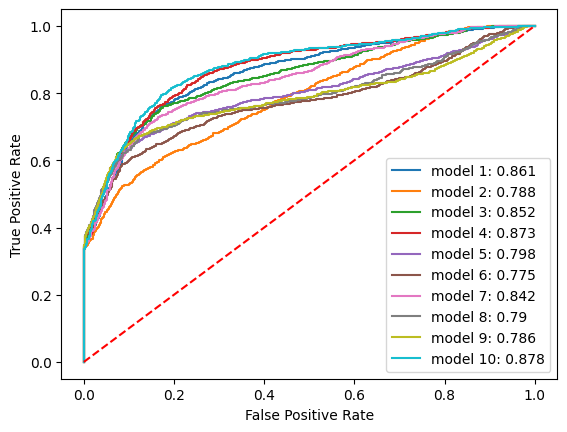

In [ ]:
auc_drop, avg_pred_drop = drop_syschronizing_ensemble(Autoencoder, 10, X_train, X_test, y_test, plot=True)

83/83 [==============================] - 0s 2ms/step


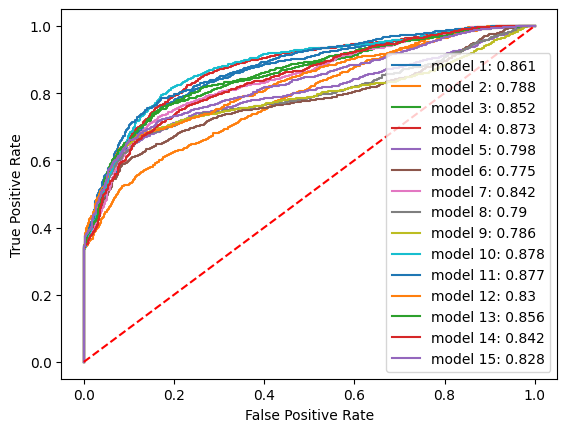

In [ ]:
auc_drop_2, avg_pred_drop_2 = drop_syschronizing_ensemble(Autoencoder, 15, X_train, X_test, y_test, plot=True)

In [ ]:
def sequential_ensemble(model_architecture, num_models, X_train, X_test, y_test, drop=False, plot=True):
  """Create a sequential syschronizing ensemble, in which the error of the current model will be used as a feature in the data used to train the next model.
  AUC score is calculated by using the error predictions of the last sychronized model

  Arguments:
    model_architecture -- architecture of model, which is used to train model
    num_models -- the number of models which are integrated in one sychronizing ensemble model
    X_train -- data which are used to train the model
    X_test -- data which are used to validate the model
    drop -- False: all the prediction errors of each previous model will be added as an feature to the original training data used for the next model
         -- True: only the prediction errors of the last model will be added as an feature to the original training data used for the next model
    plot -- draw ROC curve of all trained models in ensemble
         
  Returns: 
    auc_score_list -- AUC score lists of all models during sychronizing
    avg_pred_errors_list -- list of average pred_errors. Each element contains the average of all the difference between inputs and their predictions of one model
                            each element has shape (X_train.shape[1], 1)
  """
  # Set random seed
  tf.keras.utils.set_random_seed(42)
  # list of pred_errors. Each element contains all the difference between inputs and their predictions of one model
  avg_pred_errors_list = []
  auc_score_list = []
  X = X_train.copy()

  for i in range(num_models):
    # 1. Create model
    # if pred_errors_list is not empty, then we have to concatenate the element at position i to the current training input
    if avg_pred_errors_list:
      # convert the element at position i-1 in pred_errors_list to a 2D-tensor and then convert it to a numpy array. 
      pred_current = tf.reshape(avg_pred_errors_list[i-1], [-1, 1]).numpy()
      
      # If drop is True, only the prediction errors of the last model is concatenated to the original training data before training the next one
      if drop:
        X_plus_one = np.concatenate((X_train.copy(), pred_current), axis=1)
        # Create the next autoencoder model
        autoencoder = model_architecture(input_dim = X_plus_one.shape[1])
      # If drop is False, all the predictions errors of the previous models are concatenated to the original training data before training the next one 
      else:
        # concatenate the pred_current to X
        X = np.concatenate((X, pred_current), axis=1)
        # Create autoencoder model
        autoencoder = model_architecture(input_dim=X.shape[1])
    else:
      autoencoder = model_architecture(input_dim=X_train.shape[1])

    # 2. loss and optimizer definition
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(),
                        loss='mse',  #  Computes the mean of squares of errors between y_true & y_pred.
                        metrics=['mse']) 
    # 3. Training model
    EPOCHS = 50
    BATCH_SIZE = 128
    # Fit the autoencoder
    history = autoencoder.fit(x=X_train, 
                              y=X_train,
                              epochs=EPOCHS,
                              batch_size=BATCH_SIZE,
                              validation_data=(X_test, X_test),
                              verbose=0,
                              shuffle=True)
    if drop:
      # Fit the autoencoder
      history = autoencoder.fit(x=X_plus_one, 
                                y=X_plus_one,
                                epochs=EPOCHS,
                                batch_size=BATCH_SIZE,
                                validation_data=(X_test, X_test),
                                verbose=0,
                                shuffle=True)
      # getting predictions of the training data
      preds = autoencoder.predict(X_plus_one)
      # calculate the difference between preds and the training data using (input - preds)**2
      pred_errors = tf.math.square(tf.math.subtract(preds, X_plus_one))
      # calculate the average of pred_errors. We set axis = 1, so that the average is calculated by column-weise
      avg_preds = tf.math.reduce_mean(pred_errors, axis=1)   # shape = (X_train.shape[1], 1)
      # append avg_preds to the avg_pred_errors_list
      avg_pred_errors_list.append(avg_preds)
    else:
      # Fit the autoencoder
      history = autoencoder.fit(x=X, 
                                y=X,
                                epochs=EPOCHS,
                                batch_size=BATCH_SIZE,
                                validation_data=(X_test, X_test),
                                verbose=0,
                                shuffle=True)
      # getting predictions (recontructions) of the training data
      preds = autoencoder.predict(X)
      # calculate the difference between preds and the training data using (input - preds)**2
      pred_errors = tf.math.square(tf.math.subtract(preds, X))
      # calculate the average of pred_errors. We set axis = 1, so that the average is calculated by column-weise
      avg_preds = tf.math.reduce_mean(pred_errors, axis=1)   # shape = (X_train.shape[1], 1)
      # append avg_preds to the avg_pred_errors_list
      avg_pred_errors_list.append(avg_preds)

    # 4. Calculating AUC score of each training model
    # getting predictions of test data
    pred_test = autoencoder.predict(X_test)
    # calculate the difference between pred_test and test data 
    pred_errors_test = tf.keras.losses.mse(pred_test, X_test)
    # AUC socre 
    auc_score = roc_auc_score(y_test, pred_errors_test)
    auc_score_list.append(auc_score)
    # 5. Plot ROC Curve
    if plot:
      fpr, tpr, threshold = roc_curve(y_test, pred_errors_test)
      plt.plot(fpr, tpr, 'g', label = 'AUC = %0.2f' % auc_score)
      
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  return auc_score_list, avg_pred_errors_list
